# Guide 1. Loading raw and quality controlled ADCP data

This notebook is prepared for Moffat and Nichol by the NCSU Coastal Hazards Lab (Dr. Katherine Anarde, Levi Lavengood, Brooke Gaenzle, Elizabeth Farquhar) for the analysis, visualization, and interpretation of data collected as part of the Frying Pan Shoals Hydrodynamic Characterization project (2024-2025). Subsequent notebooks (Guides 2 - 5) will detail individual deployments and summarize bulk statistics. All scripts used for post-processing (quality control and bulk statistics) are included in the parent directory and referenced herein by name where appropriate.

**Data Collection**


Data collection for all deployments utilized two Nortek Signature 1000 High Resolution acoustic doppler current profilers (ADCPs), herein referenced as S0_103080 and S1_101481 where "S0" and "S1" refers to the position and "103080" and "101481" the serial number of the instrument. The ADCPs collected data at 4 Hz, including binned water velocities throughout the water column, water surface measurements (from the 5th beam), pressure, and instrument orientation (pitch, heading, roll) over the course of each deployment, which spanned a minimum of 20 days. Herein, we utilize data from Deployment 1 (spanning August 20th to September 19th) to illustrate the outputs of data quality control procedures. For a complete description of quality control procedures, the reader is directed to the *Sig1k_Writeup.pdf* in the same folder as this notebook. 


**1. Summary of post-processing workflow**

The ADCP onboard processor breaks data streams into multiple files for storage, with each file being 1 gigabyte in size. For Deployment 1, this resulted in approximately 30 1 GB files of raw data for each ADCP, with each file containing approximately 24 hours of data. The file types for the raw data files are .mat (`Matlab`) and the data are organized as structures. 

The first step in our post-processing workflow is to convert the .mat file to a format more manageable for data manipulation in python. Here we use the HDF5 format. Due to the size of the data stream and memory constraints we opted to post-process the data in each 1 GB .mat file individually. Herein, we use the term "groups" to organize data associated with each raw mat file. Within each group, there are HDF5 files for each variable of interest (e.g., Time.h5, Pressure.h5, NorthVel.h5). The data can be read using `pandas`, as shown below.  

**2. Loading HDF5 files**

Below is an example on how to read-in and interpret data after quality control from a single HDF5 file in Group 1 from S0-103080. First, extract the file names in the examlple directory provided:

In [2]:
# Import necessary packages
import pandas as pd
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as dt
import matplotlib.axes as axs
import matplotlib.dates as mdates

from pathlib import Path

# datadir = "BOEM_interp_data/Deploy1_Group1_S0103080/"
datadir=r"/Volumes/kanarde/BOEM/deployment_1/Processed/S0_103080/Group1"
sampling_frequency = 4

In [3]:
files = os.listdir(Path(datadir)) # list of files in Group 1
print(files) # prints out a list of all of the data files within Group 1

['DepthThresh.h5', 'AbsVel.h5', 'Time.h5', 'EastVel.h5', 'NorthVel.h5', 'VertVel.h5', 'ErrVel.h5', 'Heading.h5', 'Roll.h5', 'Pitch.h5', 'Pressure.h5', 'VelBeamCorr1.h5', 'VelBeamCorr2.h5', 'VelBeamCorr3.h5', 'VelBeamCorr4.h5', 'CellDepth.h5']


Read-in the HDF5 files containing data and create a dictionary called `data`.

In [4]:
data = {}
for file in files:
    file_path = os.path.join(datadir, file)  # file path
    if file_path==os.path.join(datadir,'DepthThresh.h5'):
        with h5py.File(file_path, 'r') as hf:
            dataset = hf['df'] 
            df = pd.DataFrame(dataset[:])  #convert to Pandas dataframe
            file_name = os.path.splitext(file)[0]  # get the file name without extension
            print(file_name)
            data[file_name] = df #store dataframe
    else:
        df = pd.read_hdf(file_path)  # read the file into a Pandas dataframe
        file_name = file_path.split('/')[-1].split('.')[0]  # file name 
        #file_name = file_path.split('\\')[-1].split('.')[0] # use this line if you're using Windows
        print(file_name)
        data[file_name] = df  # store dataframe

DepthThresh
AbsVel
Time
EastVel
NorthVel
VertVel
ErrVel
Heading
Roll
Pitch
Pressure
VelBeamCorr1
VelBeamCorr2
VelBeamCorr3
VelBeamCorr4
CellDepth


Now we can look at each parameter in our `data` dictionary, shown here for the Absolute Velocity. The rows correspond to time and the columns the binned depth (discussed below).

In [10]:
print(data['AbsVel']) 

              0         1         2         3         4         5         6   \
0            NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1            NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2            NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3            NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4            NaN       NaN       NaN       NaN       NaN       NaN       NaN   
...          ...       ...       ...       ...       ...       ...       ...   
345595  0.174225  0.229429  0.171379  0.186742  0.526882  0.202831  0.245317   
345596  0.094579  0.179882  0.145588  0.286287  0.756010  0.943179  0.954356   
345597  0.207274  0.343940  0.146397  0.586909  1.134467  0.964396  0.900018   
345598  0.178417  0.135677  0.084975  0.225680  0.348949  0.240426  0.070925   
345599  0.093963  0.275459  0.159054  0.194653  0.747966  0.655495  0.479443   

              7         8         9   .

**3. Understanding QC'ed Variables**

The **CellDepth** represents the nominal depth (m) of each cell (or "bin"). Within each cell, the ADCP reports an average value for both velocity and pressure (see figures below) for each timestep. The dimension of the CellDepth data frame here is 30 rows x 1 column, where the number of rows equals the number of cells from the location of the ADCP at the seafloor (row 0, 0.6 m -- just beyond the blanking distance) up to the water surface (row 29, 15.1 m). The number of cells does not change over time. Here, the cells are 0.5-m long. If the distance to the water surface elevation (depth) is smaller than the maximum CellDepth of 15.1 m, the data will be reported as NaNs for these cells. This can be seen in later plots within this notebook.

For plotting purposes, we create copies of this matrix to match the number of timesteps in the group.

In [25]:
print(data['CellDepth'])

       0
0    0.6
1    1.1
2    1.6
3    2.1
4    2.6
5    3.1
6    3.6
7    4.1
8    4.6
9    5.1
10   5.6
11   6.1
12   6.6
13   7.1
14   7.6
15   8.1
16   8.6
17   9.1
18   9.6
19  10.1
20  10.6
21  11.1
22  11.6
23  12.1
24  12.6
25  13.1
26  13.6
27  14.1
28  14.6
29  15.1


In [5]:
n = len(data['AbsVel'])
print(n, "time steps = ", (n/sampling_frequency)/60/60, "hrs")
df=data['CellDepth']
CellDepth = pd.DataFrame(np.repeat(df.values, n, axis=1), columns=np.tile(df.columns, n))
print(CellDepth)

345600 time steps =  24.0 hrs
       0     0     0     0     0     0     0     0     0     0  ...     0  \
0    0.6   0.6   0.6   0.6   0.6   0.6   0.6   0.6   0.6   0.6  ...   0.6   
1    1.1   1.1   1.1   1.1   1.1   1.1   1.1   1.1   1.1   1.1  ...   1.1   
2    1.6   1.6   1.6   1.6   1.6   1.6   1.6   1.6   1.6   1.6  ...   1.6   
3    2.1   2.1   2.1   2.1   2.1   2.1   2.1   2.1   2.1   2.1  ...   2.1   
4    2.6   2.6   2.6   2.6   2.6   2.6   2.6   2.6   2.6   2.6  ...   2.6   
5    3.1   3.1   3.1   3.1   3.1   3.1   3.1   3.1   3.1   3.1  ...   3.1   
6    3.6   3.6   3.6   3.6   3.6   3.6   3.6   3.6   3.6   3.6  ...   3.6   
7    4.1   4.1   4.1   4.1   4.1   4.1   4.1   4.1   4.1   4.1  ...   4.1   
8    4.6   4.6   4.6   4.6   4.6   4.6   4.6   4.6   4.6   4.6  ...   4.6   
9    5.1   5.1   5.1   5.1   5.1   5.1   5.1   5.1   5.1   5.1  ...   5.1   
10   5.6   5.6   5.6   5.6   5.6   5.6   5.6   5.6   5.6   5.6  ...   5.6   
11   6.1   6.1   6.1   6.1   6.1   6.1   6.1  

**Time** contains the date time for every measurement made by the ADCP in python’s datetime structure.

**Heading, Pitch, and Roll**: These variables represent the orientation of the sensor. Based on a qualitative assessment of deployment and retrieval conditions of the bottom-mounted sensor (the instrument was found in the position in which it was placed during deployment, see Guide 2), we expect these measurements to remain constant throughout the deployment. If they are not constant, then the sensor was displaced and additional quality control corrections will need to be made.

In [6]:
# Since we are in group 1, the first 24 hrs of data collection, we need to identify a start time that represents when the ADCP is settled at the bottom of the ocean and no longer being moved. 
start_time = datetime.datetime(2024,8,20,18,30)
print(data['Time'])
print(start_time)

                          0
0       1724151600126104000
1       1724151600376103000
2       1724151600625991000
3       1724151600876090000
4       1724151601126109000
...                     ...
345595  1724237998876091000
345596  1724237999126109000
345597  1724237999376098000
345598  1724237999626097000
345599  1724237999876095000

[345600 rows x 1 columns]
2024-08-20 18:30:00


In [7]:
#Function to convert unix timestamp in ns to regular datetime
def unix_ns_to_datetime(unix_ns_array):
    dates = []
    for date in unix_ns_array:
        seconds = date // 1_000_000_000
        nanoseconds = date % 1_000_000_000
        python_datetime = datetime.datetime.fromtimestamp(seconds) + datetime.timedelta(microseconds=nanoseconds / 1000)
        dates.append(python_datetime)
    return dates

In [8]:
#Applying the function to convert for datetime
unix_ns_array = data["Time"]
data["Datetime"] = pd.DataFrame(unix_ns_to_datetime(unix_ns_array[0].values))
print(data["Datetime"])

                                0
0      2024-08-20 07:00:00.126104
1      2024-08-20 07:00:00.376103
2      2024-08-20 07:00:00.625991
3      2024-08-20 07:00:00.876090
4      2024-08-20 07:00:01.126109
...                           ...
345595 2024-08-21 06:59:58.876091
345596 2024-08-21 06:59:59.126109
345597 2024-08-21 06:59:59.376098
345598 2024-08-21 06:59:59.626097
345599 2024-08-21 06:59:59.876095

[345600 rows x 1 columns]


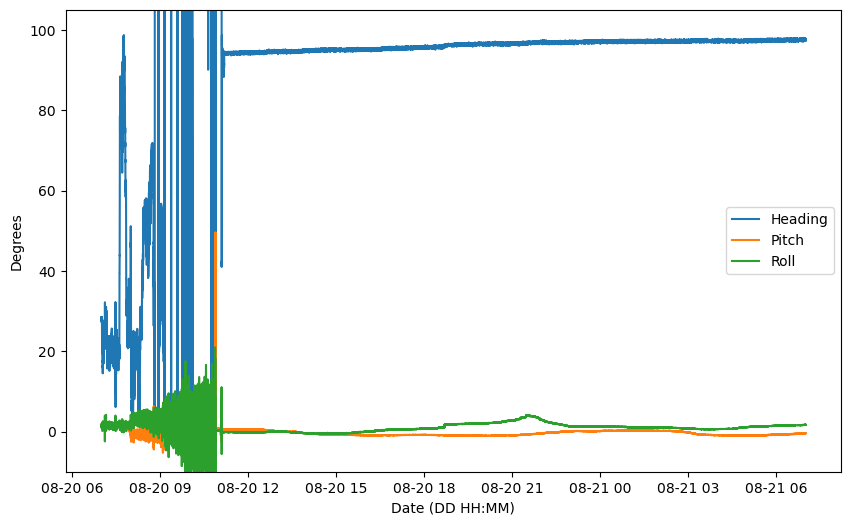

In [11]:
# Plot Heading, Pitch, and Roll over time
plt.figure(figsize=(10,6))
plt.plot(data['Datetime'],data['Heading'], label='Heading')
plt.plot(data['Datetime'],data['Pitch'], label='Pitch')
plt.plot(data['Datetime'],data['Roll'], label='Roll')
plt.xlabel('Date (DD HH:MM)')
plt.ylabel('Degrees')
plt.ylim(bottom= -10, top =105)
# plt.xlim(left=start_time) # This is here for group 1 only to cut out transportation of sensor
plt.legend()
plt.show()

In Group1, Heading and Pitch remain relatively constant, as expected. There are slight changes in Roll that can be identified from the graph.

**AbsVel(m/s)**: This is the absolute velocity. The absolute velocity is the magnitude of all the components measured. This field is useful for seeing broad trends in flow rates.  


In [12]:
# create a meshgrid of time and celldepth
x,y=np.meshgrid(data['Datetime'],data['CellDepth'])
z=data['AbsVel']

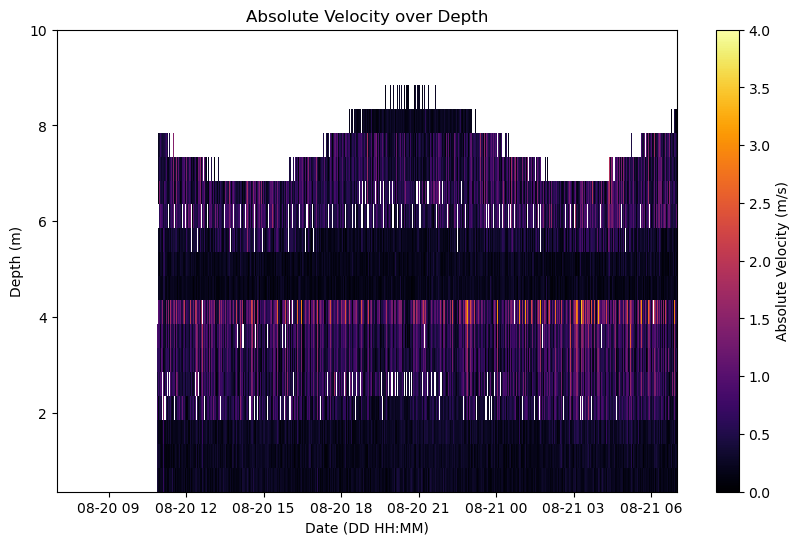

In [13]:
# Plot Velocity over time per cell
plt.figure(figsize=(10,6))
plt.pcolormesh(
    x,y,z.T, cmap='inferno', shading='nearest', vmin=0, vmax=4
)
plt.ylim(top=10)
plt.xlabel("Date (DD HH:MM)")
plt.ylabel("Depth (m)")
plt.title('Absolute Velocity over Depth')
im1=plt.colorbar()
im1.ax.set_ylabel("Absolute Velocity (m/s)")
plt.show()

We can see that depth is changing over this 24 hour period due to the tidal range. Each color strip you see on the plot represented an averaged absolute velocity per cell per each sample taken (every 0.25 seconds or 4 Hz). The white space represents empty cells where the water depth was smaller than the maximum CellDepth the ADCP can measure. It can be helpfule to think of the white cells as the air above the ocean, whereas the colored cells are data from the surface of the ocean to the top of the ADCP sensor.

**VertVel(m/s)**: This is the vertical component of the velocities measured using beam 3. Beam 3 is in the instruments "forward" direction, and is used to measure the vertical velocity. We can create a similar plot to the one above.


In [14]:
# create a meshgrid of time and celldepth
x,y=np.meshgrid(data['Datetime'],data['CellDepth'])
z=data['VertVel']

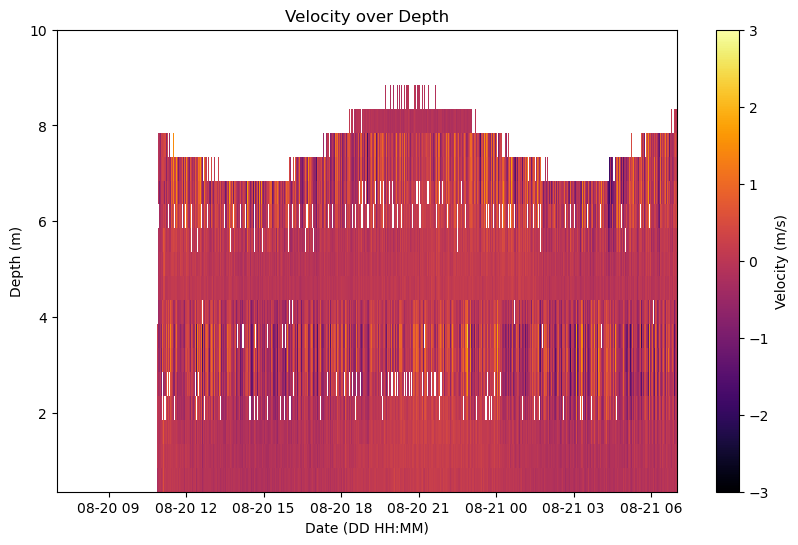

In [15]:
# Plot Velocity over time per cell
plt.figure(figsize=(10,6))
plt.pcolormesh(
    x,y,z.T, cmap='inferno', shading='nearest', vmin=-3, vmax=3 
) 
plt.ylim(top=10)
plt.xlabel("Date (DD HH:MM)")
plt.ylabel("Depth (m)")
plt.title('Velocity over Depth')
im1=plt.colorbar()
im1.ax.set_ylabel("Velocity (m/s)")
plt.show()

Again, we can see that depth is changing over this 24 hour period due to the tidal range. Each color strip you see on the plot represented an averaged vertical velocity component per cell per each sample taken (every 0.25 seconds or 4 Hz).

**EastVel and NorthVel**: These are the east and north velocity components and can be used to assess phase wrapping. Phase wrapping happens when the second signal sent out by the instrument is sent before the first signal has been received by the instrument. The instrument is then unabke to differentiate between the first and second signal, and therefore unable to record the velocity for that collection. This can be done by creating distribution plots of each component. 

These are each 345600 rows x 30 columns, where the rows represent collection time and the columns represent each cell (described in CellDepth). 


**ErrVel (m/s)**: The error velocity is made by using two different beams to measure the same velocity component, in our case the vertical velocity, and finding the difference between each. This means that if you are seeing large ErrVel values you likely have a beam failure or something interfering with the beam. Values of ~.1 are acceptable since the values are measured in slightly different locations due to the different angles of the beam. 
This dataframe is 345600 rows x 30 columns, where the rows represent collection time and the columns represent each cell. 

In [16]:
# create a meshgrid of time and celldepth
x,y=np.meshgrid(data['Datetime'],data['CellDepth'])
z=data['ErrVel']


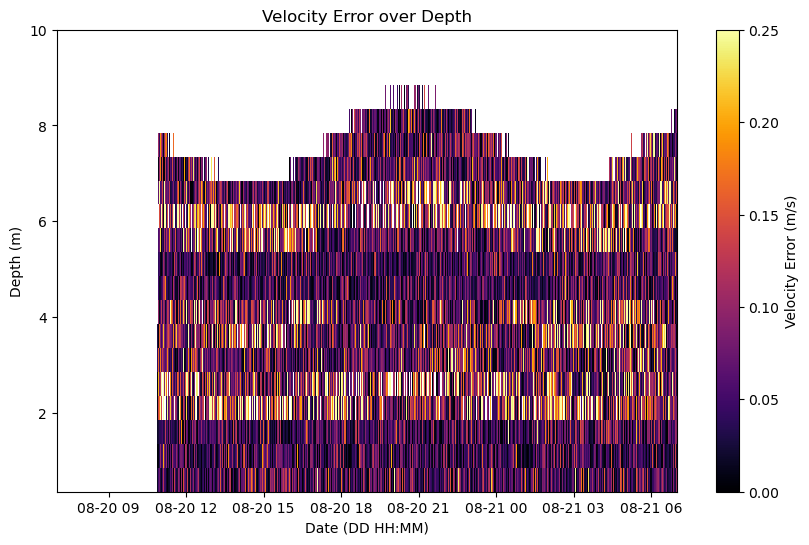

In [17]:
# Plot
plt.figure(figsize=(10,6))
plt.pcolormesh(
    x,y,z.T, cmap='inferno', shading='nearest', vmin=0, vmax=0.25
)
#plt.xlim(left=datetime(2024,8,20,18,30))
plt.ylim(top=10)
plt.xlabel("Date (DD HH:MM)")
plt.ylabel("Depth (m)")
plt.title('Velocity Error over Depth')
im1=plt.colorbar()
im1.ax.set_ylabel("Velocity Error (m/s)")
plt.show()

**Pressure (db)**: The Pressure variable represents the pressure that the sensor “feels” above it. It can be plotted for a quick check.



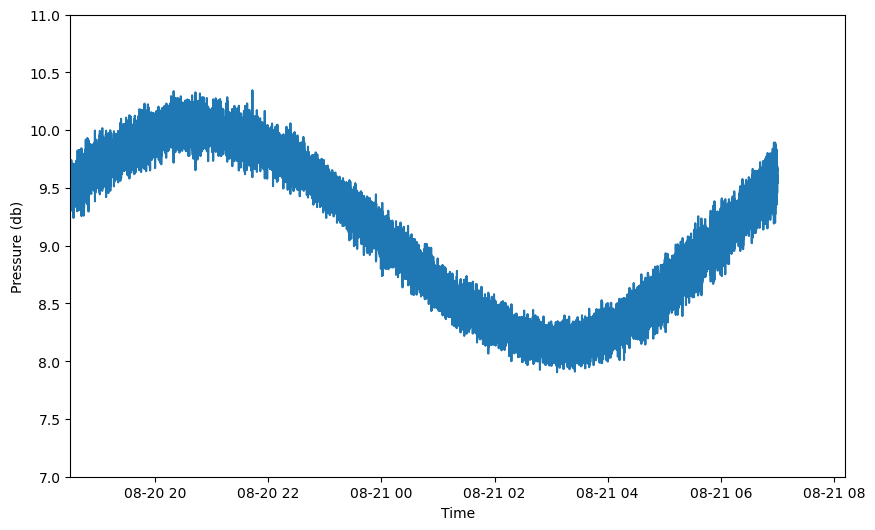

In [18]:
plt.figure(figsize=(10,6))
plt.plot(data['Datetime'],data['Pressure'])
plt.xlabel('Time')
plt.xlim(left=start_time)
plt.ylabel('Pressure (db)')
plt.ylim(bottom=7, top=11)
plt.show()

Deriving the water depth from pressure is a 1:1 conversion using the hydrostatic pressure equation. 

In [19]:
# convert db to Pa
pressure_Pa=data['Pressure']*10000
# gravitational constant
g=9.81 # (m/s)
# density of sea water 
rho=1024 # (kg/m^3)
# use hydrostatic pressure equation to relate pressure to depth (P=rho*g*h)
depth=pressure_Pa/(g*rho)

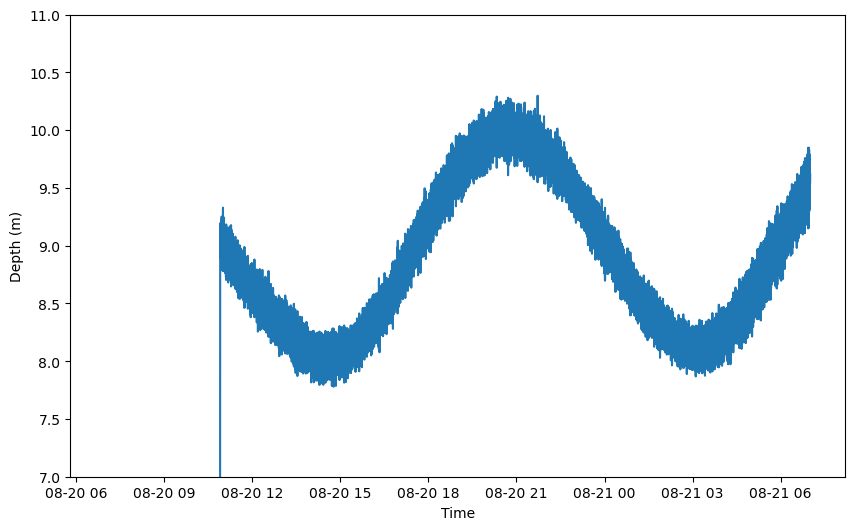

In [20]:
plt.figure(figsize=(10,6))
plt.plot(data['Datetime'],depth)
plt.xlabel('Time')
#plt.xlim(left=start_time)
plt.ylabel('Depth (m)')
plt.ylim(bottom=7, top=11)
plt.show()

**4. Understanding QC'ed Variables Not Included in Analysis**

There are still two variables that have not been discussed, VelBeamCorr1-4. If we take a look at VelBeamCorr1, we can see that it is the same size as the previously inspected velocity matrices, except it has varying column names, and it is full of zeros and ones. The ADCP collects correlation values that measure how much particle distribution has changed between measurements. These values are stored in what is called the correlation beam. We’ve taken the values stored in the correlation beam and compared them to a threshold value of 0.46. The threshold value was determined using the Elga (2001) method described in our previous quality control write-up. 

If the correlation beam value is higher than our threshold value, it means that the water particles are moving regularly, and the ADCP is receiving a valid signal. If the correlation beam value is less then the thresholding value, this means that the particle distribution has changed between measurements, and the ADCP is receiving a weak signal. A weak signal can be due to a number of things, including marine life interference, turbulence, or high sediment concentrations. 

We can also look at our DepthThresh variable, this represents where the water surface is. 

In [193]:
print(data['VelBeamCorr1'])

          0      4      8      12     16     20     24     28     32     36   \
0        True   True   True   True   True   True   True   True   True   True   
1        True   True   True   True   True   True   True   True   True   True   
2        True   True   True   True   True   True   True   True   True   True   
3        True   True   True   True   True   True   True   True   True   True   
4        True   True   True   True   True   True   True   True   True   True   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
345595  False  False  False  False  False  False  False  False  False  False   
345596  False  False  False  False  False  False  False  False  False  False   
345597  False  False  False  False  False  False  False  False  False  False   
345598  False  False  False  False  False  False  False  False  False  False   
345599  False  False  False  False  False  False  False  False  False  False   

        ...    80     84     88     92 

In [194]:
print(data['DepthThresh'])

           0      1      2      3      4      5      6      7      8      9   \
0        True   True   True   True   True   True   True   True   True   True   
1        True   True   True   True   True   True   True   True   True   True   
2        True   True   True   True   True   True   True   True   True   True   
3        True   True   True   True   True   True   True   True   True   True   
4        True   True   True   True   True   True   True   True   True   True   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
345595  False  False  False  False  False  False  False  False  False  False   
345596  False  False  False  False  False  False  False  False  False  False   
345597  False  False  False  False  False  False  False  False  False  False   
345598  False  False  False  False  False  False  False  False  False  False   
345599  False  False  False  False  False  False  False  False  False  False   

        ...    20    21    22    23    

There is a correlation beam value stored for each of the 4 beams of the ADCP. VelBeamCorr1 contains correlation values for EastVel, VelBeamCorr2 contains values for NorthVel, VelBeamCorr3 contains values for VertVel, and VelBeamCorr4 contains values for ErrVel. After comparing correlation values to our threshold, a binary mask was made to apply to our velocity measurements (from the 4 beams). High correlation values were made to be 0 and low correlation values were made to be 1. Let's inspect each of the correlation beams and their respective velocity beam.

First, we need to apply our DepthThresh mask over our correlation values, that way we are only looking at values measured under the water's surface.

In [ ]:
for jj in range(1,5):
    df1=data['DepthThresh']
    df2=data[f"VelBeamCorr{jj}"]
    df1.columns=df2.columns
    df_masked=df2.mask(df1,1)
    data[f"VelBeamCorr{jj}"]=df_masked.astype(int)

In [19]:
# create a meshgrid of time and celldepth
x,y=np.meshgrid(data['Datetime'],data['CellDepth'])
z1=data['VelBeamCorr1']
z2=data['EastVel']
z3=data['VelBeamCorr2']
z4=data['NorthVel']
z5=data['VelBeamCorr3']
z6=data['VertVel']
z7=data['VelBeamCorr4']
z8=data['ErrVel']


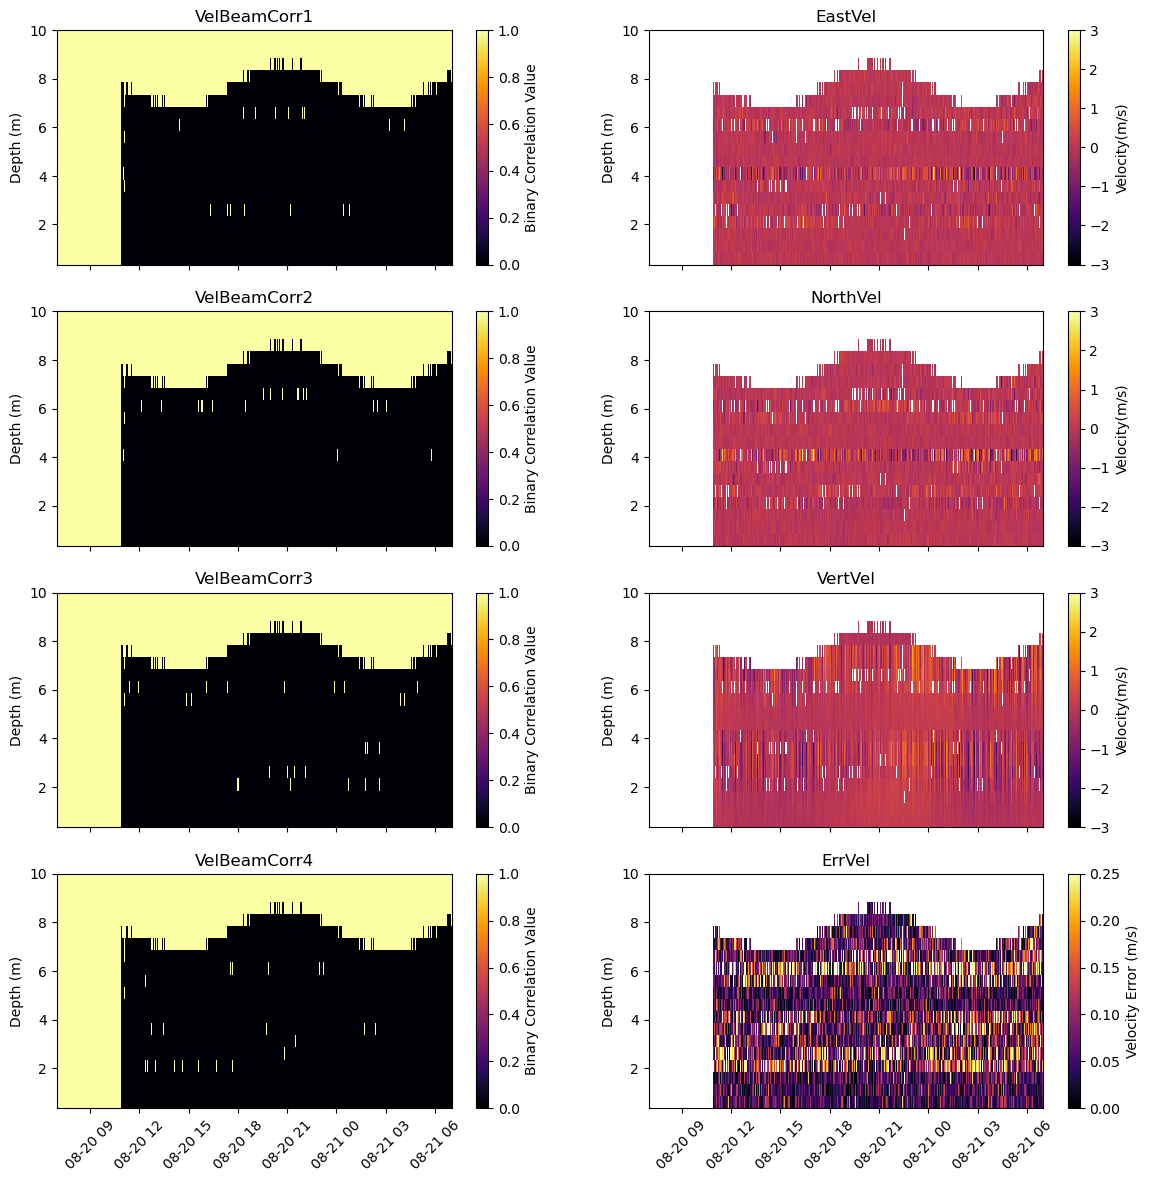

In [20]:
# Plot Velocity over time per cell
fig=plt.figure(figsize=(14,14))
fig.tight_layout()

plt.subplot(4,2,1)
pc1=plt.pcolormesh(
    x,y,z1.T, cmap='inferno', shading='nearest', vmin=0, vmax=1
) 
plt.ylim(top=10)
plt.ylabel("Depth (m)")
plt.title('VelBeamCorr1')
plt.xticks(rotation=45)
plt.gca().set_xticklabels([])  # Removes the x-tick labels
im=plt.colorbar()
im.ax.set_ylabel("Binary Correlation Value")

plt.subplot(4,2,2)
pc2=plt.pcolormesh(
    x,y,z2.T, cmap='inferno', shading='nearest', vmin=-3, vmax=3
) 
plt.ylim(top=10)
plt.ylabel("Depth (m)")
plt.title('EastVel')
plt.xticks(rotation=45)
plt.gca().set_xticklabels([])  # Removes the x-tick labels
im1=plt.colorbar()
im1.ax.set_ylabel("Velocity(m/s)")

plt.subplot(4,2,3)
pc1=plt.pcolormesh(
    x,y,z3.T, cmap='inferno', shading='nearest', vmin=0, vmax=1
) 
plt.ylim(top=10)
plt.ylabel("Depth (m)")
plt.title('VelBeamCorr2')
plt.xticks(rotation=45)
plt.gca().set_xticklabels([])  # Removes the x-tick labels
im=plt.colorbar()
im.ax.set_ylabel("Binary Correlation Value")

plt.subplot(4,2,4)
pc2=plt.pcolormesh(
    x,y,z4.T, cmap='inferno', shading='nearest', vmin=-3, vmax=3
) 
plt.ylim(top=10)
plt.ylabel("Depth (m)")
plt.title('NorthVel')
plt.xticks(rotation=45)
plt.gca().set_xticklabels([])  # Removes the x-tick labels
im1=plt.colorbar()
im1.ax.set_ylabel("Velocity(m/s)")

plt.subplot(4,2,5)
pc1=plt.pcolormesh(
    x,y,z5.T, cmap='inferno', shading='nearest', vmin=0, vmax=1
) 
plt.ylim(top=10)
plt.ylabel("Depth (m)")
plt.title('VelBeamCorr3')
plt.xticks(rotation=45)
plt.gca().set_xticklabels([])  # Removes the x-tick labels
im=plt.colorbar()
im.ax.set_ylabel("Binary Correlation Value")

plt.subplot(4,2,6)
pc2=plt.pcolormesh(
    x,y,z6.T, cmap='inferno', shading='nearest', vmin=-3, vmax=3
) 
plt.ylim(top=10)
plt.ylabel("Depth (m)")
plt.title('VertVel')
plt.xticks(rotation=45)
plt.gca().set_xticklabels([])  # Removes the x-tick labels
im1=plt.colorbar()
im1.ax.set_ylabel("Velocity(m/s)")

plt.subplot(4,2,7)
pc1=plt.pcolormesh(
    x,y,z7.T, cmap='inferno', shading='nearest', vmin=0, vmax=1
) 
plt.ylim(top=10)
plt.ylabel("Depth (m)")
plt.title('VelBeamCorr4')
plt.xticks(rotation=45)
im=plt.colorbar()
im.ax.set_ylabel("Binary Correlation Value")

plt.subplot(4,2,8)
pc2=plt.pcolormesh(
    x,y,z8.T, cmap='inferno', shading='nearest',vmin=0, vmax=0.25
) 
plt.ylim(top=10)
plt.ylabel("Depth (m)")
plt.title('ErrVel')
plt.xticks(rotation=45)
im1=plt.colorbar()
im1.ax.set_ylabel("Velocity Error (m/s)")



plt.show()

We can observe that the blank or white cells in EastVel, NorthVel, VertVel, and ErrVel correlate to the yell cells in their respective VelBeamCorr plots. These cells represent where the data was deemed unusable due to the low correlation value recorded by the ADCP. We can also look at this quantitatively and determine what percentage of cells were used in further analysis. 